# vLife Virtusa
## Predicting Adverse Side Effects 
### Usecase Description
***An adverse drug reaction (ADR) is an injury caused by taking medication. ADRs may occur following a single dose or prolonged administration of a drug or result from the combination of two or more drugs. When patients suffer unintended reactions to medicines, it can be both dangerous for the individual and costly to society. Using ML models, this tool would help medical professionals to forecast adverse drug reactions (ADRs) and minimise risks to patients. Model used is Random Forest( One vs Rest Classifier)***


This notebook involves implementation of a hierarchical anatomical schema for aggregation of side effects <b>Towards prediction of side effects (multi-class, multi-label setting) using existing data (SIDER4) </b> by leveraging machine learning and statistical data analysis. During the course of this usecase, the following tasks were performed: <br>

1) Extraction of relevant data of drug side effects, chemical properties etc. <br>
2) Hierarchical classification of side effects based on organ/system involved <br>
3) Data preprocessing. <br>
4) Implementation of machine learning algorithms for prediction of side effects.<br>

### Data Source
Data set for this usecase can be found [here](http://sideeffects.embl.de/download/).


### Dataset Description
<p> SIDER contains information on marketed medicines and their recorded adverse drug reactions. The information is extracted from public documents and package inserts. The available information include side effect frequency, drug and side effect classifications as well as links to further information, for example drug–target relations.Also We used the MedDRA dictionary to extract side effects from drug labels.</p>

##### Importing Required Libraries

In [2]:
import pandas as pd
import numpy as np
import pickle

from sklearn.preprocessing import scale, MinMaxScaler, StandardScaler
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.decomposition import PCA
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import fbeta_score, precision_score, make_scorer, average_precision_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split

import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import interp
from itertools import cycle
from sklearn.metrics import auc, roc_curve, roc_auc_score

## I. Data Preprocessing
<p> Preprocessing the meddra_all_se.tsv File that is  obtained from SIDER containing drug-ADR associations. </p>

In [4]:
def stitch_to_pubchem(_id):
    assert _id.startswith("CID")
    return int(int(_id[3:]) - 1e8)

In [5]:
columns = [
    'stitch_id_flat',
    'stitch_id_sterio',
    'umls_cui_from_label',
    'meddra_type',
    'umls_cui_from_meddra',
    'side_effect_name',
]

In [6]:
df = pd.read_table('../data/meddra_all_se.tsv', names=columns)
df.drop(df[df.meddra_type == "LLT"].index, inplace=True)
print (df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 164107 entries, 1 to 309848
Data columns (total 6 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   stitch_id_flat        164107 non-null  object
 1   stitch_id_sterio      164107 non-null  object
 2   umls_cui_from_label   164107 non-null  object
 3   meddra_type           163206 non-null  object
 4   umls_cui_from_meddra  163206 non-null  object
 5   side_effect_name      164107 non-null  object
dtypes: object(6)
memory usage: 8.8+ MB
None


> Merging 2d_prop.xlsx & 3d_prop.xls with the side effects.  2d_prop.xlsx & 3d_prop.xls contains Chemical Properties for 1430 drugs generated using DiscoveryStudio4. They form the basis of our feature set.

In [7]:
df = df.groupby('stitch_id_flat').side_effect_name.apply(list).reset_index()
df['pubchem_id'] = df.stitch_id_flat.map(stitch_to_pubchem)
print (df.head())

d2 = pd.read_excel("../data/2d_prop.xlsx")
d3 = pd.read_excel("../data/3d_prop.xlsx")
print (d2.shape, d3.shape)

  stitch_id_flat                                   side_effect_name  \
0   CID100000085  [Abdominal pain, Gastrointestinal pain, Abdomi...   
1   CID100000119  [Anaphylactic shock, Angioedema, Pain, Urticar...   
2   CID100000137  [Anaemia, Aphasia, Mental disorder, Brain neop...   
3   CID100000143  [Alopecia, Decreased appetite, Infection, Cons...   
4   CID100000146                                    [Sensitisation]   

   pubchem_id  
0          85  
1         119  
2         137  
3         143  
4         146  
(1430, 330) (1430, 57)


In [8]:
d2 = d2.select_dtypes(include=['int64','float64'])
d3 = d3.select_dtypes(include=['float64'])

In [9]:
df = pd.concat([df, d2, d3], axis=1)

In [10]:
df.drop("stitch_id_flat", inplace=True, axis=1)

#####  Final Dataset after Data Preprocessing
>This dataset consists of details of all the anatomical systems and their associated side effects

In [22]:
df

,side_effect_name,pubchem_id,ES_Count_aaaC,ES_Count_aaCH,ES_Count_aaN,ES_Count_aaNH,ES_Count_aaO,ES_Count_aaS,ES_Count_aasC,ES_Count_aaSe,...,Shadow_XZfrac,Shadow_Ylength,Shadow_YZ,Shadow_YZfrac,Shadow_Zlength,Molecular_3D_PolarSASA,Molecular_3D_SASA,Molecular_3D_SAVol,Molecular_Volume,bool
0,"[Abdominal pain, Gastrointestinal pain, Abdomi...",85,0,0,0,0,0,0,0,0,...,0.64794,6.51483,26.8887,0.67644,6.10150,119.843,351.103,314.850,148.86,True
1,"[Anaphylactic shock, Angioedema, Pain, Urticar...",119,0,0,0,0,0,0,0,0,...,0.70766,5.39090,16.9354,0.74074,4.24099,161.125,280.752,251.605,87.80,False
2,"[Anaemia, Aphasia, Mental disorder, Brain neop...",137,0,0,0,0,0,0,0,0,...,0.71690,5.61124,18.0214,0.76332,4.20748,190.905,313.352,284.088,108.04,True
3,"[Alopecia, Decreased appetite, Infection, Cons...",143,0,4,0,0,0,0,2,0,...,0.62444,8.87816,32.6860,0.67619,5.44464,433.683,757.502,702.245,350.20,True
4,[Sensitisation],146,0,4,0,0,0,0,2,0,...,0.62444,8.85582,33.1233,0.68492,5.46090,401.641,763.528,704.631,351.91,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1425,"[Anaphylactic shock, Angioedema, Aortic aneury...",56603655,0,0,0,0,0,0,0,0,...,0.71242,17.55240,72.4226,0.71473,5.77289,316.173,1036.850,922.986,458.24,True
1426,"[Anaphylactic shock, Constipation, Dysgeusia, ...",56842239,0,0,0,0,0,0,0,0,...,0.71150,8.01208,31.7555,0.73803,5.37030,278.998,1968.780,1764.040,836.23,True
1427,"[Angioedema, Chest pain, Connective tissue dis...",70683024,0,0,0,0,0,0,0,0,...,0.62443,15.42600,67.8677,0.64029,6.87118,562.814,1065.070,959.552,566.63,False
1428,"[Gastrointestinal pain, Abdominal pain, Acidos...",70695640,0,8,0,0,0,0,4,0,...,0.60637,8.09454,35.0885,0.67553,6.41687,124.690,717.604,661.350,305.26,True


## II. Filtering the dataset for Digestive system 

In [11]:
df3=pd.read_csv('system.csv')
df3 = df3[['DIGESTIVE SYSTEM']]
df3.head(144)
df3 = df3['DIGESTIVE SYSTEM'].tolist()
df3

['Burning mouth syndrome',
 'Dry mouth',
 'Foot and mouth disease',
 'Mouth haemorrhage',
 'Mouth injury',
 'Mouth ulceration',
 'Oedema mouth',
 'Leukoplakia oral',
 'Oral candidiasis',
 'Oral discomfort',
 'Oral disorder',
 'Oral fungal infection',
 'Oral herpes',
 'Oral infection',
 'Oral mucosa erosion',
 'Oral mucosal blistering',
 'Oral mucosal discolouration',
 'Oral mucosal exfoliation',
 'Oral neoplasm',
 'Oral neoplasm benign',
 'Oral pain',
 'Oral papilloma',
 'Oral pruritus',
 'Oral pustule',
 'Oral toxicity',
 'Oromandibular dystonia',
 'Pain in jaw',
 'Periodontal destruction',
 'Periodontal disease',
 'Periodontitis',
 'Stomatitis',
 'Stomatitis necrotising',
 'Thirst',
 'Aphthous stomatitis',
 'Chapped lips',
 'Congenital oral malformation',
 'Lip blister',
 'Lip dry',
 'Lip haemorrhage',
 'Lip oedema',
 'Lip pain',
 'Lip swelling',
 'Lip ulceration',
 'Parotid duct obstruction',
 'Parotid gland enlargement',
 'Parotid gland inflammation',
 'Parotitis',
 'Saliva altered

In [12]:
j=0
df['bool'] = ''
for i in df['side_effect_name']:
    c=any(item in i for item in df3)
    df['bool'][j]=c
    j+=1

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [13]:
df2 = df.loc[df['bool'] == bool(True)]
df2 = df2.reset_index()
df2.drop("index", inplace=True, axis=1)
df2.drop("bool", inplace=True, axis=1)
df2

,side_effect_name,pubchem_id,ES_Count_aaaC,ES_Count_aaCH,ES_Count_aaN,ES_Count_aaNH,ES_Count_aaO,ES_Count_aaS,ES_Count_aasC,ES_Count_aaSe,...,Shadow_XZ,Shadow_XZfrac,Shadow_Ylength,Shadow_YZ,Shadow_YZfrac,Shadow_Zlength,Molecular_3D_PolarSASA,Molecular_3D_SASA,Molecular_3D_SAVol,Molecular_Volume
0,"[Abdominal pain, Gastrointestinal pain, Abdomi...",85,0,0,0,0,0,0,0,0,...,45.1038,0.64794,6.51483,26.8887,0.67644,6.10150,119.843,351.103,314.850,148.86
1,"[Anaemia, Aphasia, Mental disorder, Brain neop...",137,0,0,0,0,0,0,0,0,...,34.3635,0.71690,5.61124,18.0214,0.76332,4.20748,190.905,313.352,284.088,108.04
2,"[Alopecia, Decreased appetite, Infection, Cons...",143,0,4,0,0,0,0,2,0,...,86.5082,0.62444,8.87816,32.6860,0.67619,5.44464,433.683,757.502,702.245,350.20
3,"[Gastrointestinal pain, Abdominal pain, Premat...",158,0,0,0,0,0,0,0,0,...,94.6015,0.70114,9.92363,42.3569,0.75586,5.64691,220.790,707.588,628.138,312.81
4,"[Gastrointestinal pain, Abdominal pain, Anaphy...",159,0,0,0,0,0,0,0,0,...,93.3488,0.69257,8.87128,33.9609,0.70793,5.40752,194.490,692.945,611.304,304.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1320,"[Gastrointestinal pain, Abdominal pain, Anaphy...",54687131,0,3,0,0,0,0,3,0,...,115.0460,0.63927,11.07670,47.4630,0.70276,6.09728,424.007,920.996,837.035,487.74
1321,"[Anaphylactic shock, Angioedema, Aortic aneury...",56603655,0,0,0,0,0,0,0,0,...,127.8160,0.71242,17.55240,72.4226,0.71473,5.77289,316.173,1036.850,922.986,458.24
1322,"[Anaphylactic shock, Constipation, Dysgeusia, ...",56842239,0,0,0,0,0,0,0,0,...,101.5490,0.71150,8.01208,31.7555,0.73803,5.37030,278.998,1968.780,1764.040,836.23
1323,"[Gastrointestinal pain, Abdominal pain, Acidos...",70695640,0,8,0,0,0,0,4,0,...,74.7485,0.60637,8.09454,35.0885,0.67553,6.41687,124.690,717.604,661.350,305.26


In [39]:
df1 = df2

In [15]:
df1['side_effect_name'][1295]

['Alopecia',
 'Decreased appetite',
 'Arthralgia',
 'Musculoskeletal discomfort',
 'Ascites',
 'Asthenia',
 'Transient ischaemic attack',
 'Chest pain',
 'Conjunctivitis',
 'Constipation',
 'Cystitis noninfective',
 'Cystitis',
 'Bladder pain',
 'Disturbance in sexual arousal',
 'Libido decreased',
 'Depression',
 'Diarrhoea',
 'Dizziness',
 'Dysgeusia',
 'Dyspnoea',
 'Dysuria',
 'Ear pain',
 'Oedema',
 'Epistaxis',
 'Rash',
 'Dermatitis',
 'Gastritis',
 'Gynaecomastia',
 'Headache',
 'Herpes simplex',
 'Hirsutism',
 'Libido increased',
 'Disturbance in sexual arousal',
 'Breast pain',
 'Chloasma',
 'Menopause',
 'Menstrual disorder',
 'Myocardial infarction',
 'Acute coronary syndrome',
 'Nausea',
 'Neoplasm',
 'Nervousness',
 'Tension',
 'Neurosis',
 'Oliguria',
 'Ophthalmoplegia',
 'IIIrd nerve paralysis',
 'Osteopenia',
 'Palpitations',
 'Paraesthesia',
 'Pituitary tumour benign',
 'Pituitary haemorrhage',
 'Pleural effusion',
 'Multiple pregnancy',
 'Pruritus',
 'Puberty',
 'Pulmo

In [16]:
k=0
df1['side_effect'] = ''
for i in df1['side_effect_name']:
    new = []
    j = 0
    length = len(i)
    #print(length)
    while j < length:
        if i[j] in df3:
            c = i[j]
            new.append(c)
            unique = set(new)
            new_1 = list(unique)
        j = j+1
    df1['side_effect'][k] =new_1   
    k = k+1    

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


> **Final Dataset for Digestive System**

In [17]:
df1

,side_effect_name,pubchem_id,ES_Count_aaaC,ES_Count_aaCH,ES_Count_aaN,ES_Count_aaNH,ES_Count_aaO,ES_Count_aaS,ES_Count_aasC,ES_Count_aaSe,...,Shadow_XZfrac,Shadow_Ylength,Shadow_YZ,Shadow_YZfrac,Shadow_Zlength,Molecular_3D_PolarSASA,Molecular_3D_SASA,Molecular_3D_SAVol,Molecular_Volume,side_effect
0,"[Abdominal pain, Gastrointestinal pain, Abdomi...",85,0,0,0,0,0,0,0,0,...,0.64794,6.51483,26.8887,0.67644,6.10150,119.843,351.103,314.850,148.86,"[Abdominal pain, Gastric atony, Melaena, Gastr..."
1,"[Anaemia, Aphasia, Mental disorder, Brain neop...",137,0,0,0,0,0,0,0,0,...,0.71690,5.61124,18.0214,0.76332,4.20748,190.905,313.352,284.088,108.04,"[Gastrointestinal disorder, Blood bilirubin in..."
2,"[Alopecia, Decreased appetite, Infection, Cons...",143,0,4,0,0,0,0,2,0,...,0.62444,8.87816,32.6860,0.67619,5.44464,433.683,757.502,702.245,350.20,"[Stomatitis, Abdominal pain, Abdominal pain lo..."
3,"[Gastrointestinal pain, Abdominal pain, Premat...",158,0,0,0,0,0,0,0,0,...,0.70114,9.92363,42.3569,0.75586,5.64691,220.790,707.588,628.138,312.81,"[Abdominal pain, Diarrhoea, Laryngitis, Pharyn..."
4,"[Gastrointestinal pain, Abdominal pain, Anaphy...",159,0,0,0,0,0,0,0,0,...,0.69257,8.87128,33.9609,0.70793,5.40752,194.490,692.945,611.304,304.92,"[Abdominal pain, Flatulence, Thirst, Dry mouth..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1320,"[Gastrointestinal pain, Abdominal pain, Anaphy...",54687131,0,3,0,0,0,0,3,0,...,0.63927,11.07670,47.4630,0.70276,6.09728,424.007,920.996,837.035,487.74,"[Abdominal pain, Stomatitis, Hepatic failure, ..."
1321,"[Anaphylactic shock, Angioedema, Aortic aneury...",56603655,0,0,0,0,0,0,0,0,...,0.71242,17.55240,72.4226,0.71473,5.77289,316.173,1036.850,922.986,458.24,"[Gastrointestinal disorder, Diarrhoea, Dyspeps..."
1322,"[Anaphylactic shock, Constipation, Dysgeusia, ...",56842239,0,0,0,0,0,0,0,0,...,0.71150,8.01208,31.7555,0.73803,5.37030,278.998,1968.780,1764.040,836.23,"[Gastrointestinal disorder, Constipation, Dysp..."
1323,"[Gastrointestinal pain, Abdominal pain, Acidos...",70695640,0,8,0,0,0,0,4,0,...,0.60637,8.09454,35.0885,0.67553,6.41687,124.690,717.604,661.350,305.26,"[Dysphagia, Diverticulitis, Hepatocellular inj..."


> **Removing labels from the Digestive system dataset**

In [18]:
df1.drop("side_effect_name", inplace=True, axis=1)

In [19]:
df1

,pubchem_id,ES_Count_aaaC,ES_Count_aaCH,ES_Count_aaN,ES_Count_aaNH,ES_Count_aaO,ES_Count_aaS,ES_Count_aasC,ES_Count_aaSe,ES_Count_aasN,...,Shadow_XZfrac,Shadow_Ylength,Shadow_YZ,Shadow_YZfrac,Shadow_Zlength,Molecular_3D_PolarSASA,Molecular_3D_SASA,Molecular_3D_SAVol,Molecular_Volume,side_effect
0,85,0,0,0,0,0,0,0,0,0,...,0.64794,6.51483,26.8887,0.67644,6.10150,119.843,351.103,314.850,148.86,"[Abdominal pain, Gastric atony, Melaena, Gastr..."
1,137,0,0,0,0,0,0,0,0,0,...,0.71690,5.61124,18.0214,0.76332,4.20748,190.905,313.352,284.088,108.04,"[Gastrointestinal disorder, Blood bilirubin in..."
2,143,0,4,0,0,0,0,2,0,0,...,0.62444,8.87816,32.6860,0.67619,5.44464,433.683,757.502,702.245,350.20,"[Stomatitis, Abdominal pain, Abdominal pain lo..."
3,158,0,0,0,0,0,0,0,0,0,...,0.70114,9.92363,42.3569,0.75586,5.64691,220.790,707.588,628.138,312.81,"[Abdominal pain, Diarrhoea, Laryngitis, Pharyn..."
4,159,0,0,0,0,0,0,0,0,0,...,0.69257,8.87128,33.9609,0.70793,5.40752,194.490,692.945,611.304,304.92,"[Abdominal pain, Flatulence, Thirst, Dry mouth..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1320,54687131,0,3,0,0,0,0,3,0,0,...,0.63927,11.07670,47.4630,0.70276,6.09728,424.007,920.996,837.035,487.74,"[Abdominal pain, Stomatitis, Hepatic failure, ..."
1321,56603655,0,0,0,0,0,0,0,0,0,...,0.71242,17.55240,72.4226,0.71473,5.77289,316.173,1036.850,922.986,458.24,"[Gastrointestinal disorder, Diarrhoea, Dyspeps..."
1322,56842239,0,0,0,0,0,0,0,0,0,...,0.71150,8.01208,31.7555,0.73803,5.37030,278.998,1968.780,1764.040,836.23,"[Gastrointestinal disorder, Constipation, Dysp..."
1323,70695640,0,8,0,0,0,0,4,0,0,...,0.60637,8.09454,35.0885,0.67553,6.41687,124.690,717.604,661.350,305.26,"[Dysphagia, Diverticulitis, Hepatocellular inj..."


In [19]:
df = df1

> **Extracting labels from the dataset**

In [23]:
X = df.drop("side_effect_name", axis=1)

In [27]:
Y = df[df.columns[0]]
Y

0       [Abdominal pain, Gastrointestinal pain, Abdomi...
1       [Anaphylactic shock, Angioedema, Pain, Urticar...
2       [Anaemia, Aphasia, Mental disorder, Brain neop...
3       [Alopecia, Decreased appetite, Infection, Cons...
4                                         [Sensitisation]
                              ...                        
1425    [Anaphylactic shock, Angioedema, Aortic aneury...
1426    [Anaphylactic shock, Constipation, Dysgeusia, ...
1427    [Angioedema, Chest pain, Connective tissue dis...
1428    [Gastrointestinal pain, Abdominal pain, Acidos...
1429    [Abdominal distension, Gastrointestinal pain, ...
Name: side_effect_name, Length: 1430, dtype: object

> **One Hot Encoding Categorical Columns**

In [28]:
X.fillna(X.mean(), inplace=True)
mlb = MultiLabelBinarizer()
y=mlb.fit_transform(Y)
#pca = PCA(n_components=100)# adjust yourself

> **Train-test Split**

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)
#pca.fit(X)
#scaler=StandardScaler()
#scaler.fit(X)
#X_train1 = scaler.transform(X_train)
#X_test1=scaler.transform(X_test)
#X_t_train = pca.transform(X_train1)
#X_t_test = pca.transform(X_test1)

## II. Predictive Models

### Model Selection

> **Logistic Regression**

In [38]:
clf=OneVsRestClassifier(LogisticRegression(C=20, penalty='l2'))
clf.fit(X_train, y_train)

In [31]:
score=fbeta_score(y_test, clf.predict(X_test), beta=2, average=None)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


In [32]:
avg_sample_score=fbeta_score(y_test, clf.predict(X_test), beta=2, average='samples')

In [33]:
avg_prec=average_precision_score(y_test.T, clf.predict(X_test).T)

In [34]:
metrics = [score, avg_sample_score, roc_auc_score(y_test.T, clf.predict_proba(X_test).T)]

In [35]:
app = dict()

In [36]:
app['Classwise Scores'] = ([(mlb.classes_[l], score[l]) for l in score.argsort()[::-1]])
app['F2 Score'] = avg_sample_score
app['ROC_AUC'] = roc_auc_score(y_test.T, clf.predict_proba(X_test).T)
app['Precision Score Avg (PR Curve)'] = avg_prec

In [32]:
app

{'Classwise Scores': [('Nausea', 0.22395326192794546),
  ('Vomiting', 0.16720604099244873),
  ('Diarrhoea', 0.10841836734693877),
  ('Gastrointestinal disorder', 0.03252032520325203),
  ('Gastrointestinal candidiasis', 0.0),
  ('Gastric ulcer perforation', 0.0),
  ('Gastrinoma', 0.0),
  ('Gastritis', 0.0),
  ('Gastritis erosive', 0.0),
  ('Gastritis haemorrhagic', 0.0),
  ('Gastritis viral', 0.0),
  ('Gastroduodenitis', 0.0),
  ('Gastroenteritis', 0.0),
  ('Gastroenteritis bacterial', 0.0),
  ('Gastroenteritis salmonella', 0.0),
  ('Gastroenteritis yersinia', 0.0),
  ('Gastrointestinal carcinoma', 0.0),
  ('Gastric ulcer haemorrhage', 0.0),
  ('Gastrointestinal fistula', 0.0),
  ('Gastrointestinal fungal infection', 0.0),
  ('Gastrointestinal haemorrhage', 0.0),
  ('Gastrointestinal hypermotility', 0.0),
  ('Gastrointestinal hypomotility', 0.0),
  ('Gastrointestinal infection', 0.0),
  ('Gastrointestinal inflammation', 0.0),
  ('Gastrointestinal inflammatory conditions', 0.0),
  ('Gast

In [33]:
pre=clf.predict(X_test.loc[1192].to_frame().T)
a = mlb.inverse_transform(pre)
a

[('Nausea', 'Vomiting')]

In [34]:
df1.iloc[1192]['side_effect']  

['Vomiting',
 'Abdominal pain',
 'Hepatobiliary disease',
 'Rectal haemorrhage',
 'Melaena',
 'Diarrhoea',
 'Hepatitis cholestatic',
 'Aspartate aminotransferase increased',
 'Gastrointestinal disorder',
 'Hepatocellular injury',
 'Gastrointestinal pain',
 'Constipation',
 'Nausea',
 'Liver injury',
 'Flatulence',
 'Alanine aminotransferase increased',
 'Gastrointestinal haemorrhage',
 'Dyspepsia',
 'Intra-abdominal haemorrhage']

> **Random Forest**

In [63]:
clf1=OneVsRestClassifier(RandomForestClassifier(n_estimators=200, max_depth=6, random_state=42, min_samples_split=10))
clf1.fit(X_train, y_train)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 27 is present in all training examples.
  str(classes[c]))
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 30 is present in all training examples.
  str(classes[c]))
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 42 is present in all training examples.
  str(classes[c]))
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 57 is present in 

OneVsRestClassifier(estimator=RandomForestClassifier(bootstrap=True,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=6,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=10,
                                                     min_weight_fraction_leaf=0.0,
                                                     n_estimators=200,
                                                     n_jobs=None,
                                                

In [64]:
score=fbeta_score(y_test, clf1.predict(X_test), beta=2, average=None)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [65]:
avg_sample_score=fbeta_score(y_test, clf1.predict(X_test), beta=2, average='samples')

In [66]:
avg_prec=average_precision_score(y_test.T, clf1.predict(X_test).T)

In [67]:
metrics = [score, avg_sample_score, roc_auc_score(y_test.T, clf1.predict_proba(X_test).T)]

In [68]:
app = dict()

In [69]:
app['Classwise Scores'] = ([(mlb.classes_[l], score[l]) for l in score.argsort()[::-1]])
app['F2 Score'] = avg_sample_score
app['ROC_AUC'] = roc_auc_score(y_test.T, clf1.predict_proba(X_test).T)
app['Precision Score Avg (PR Curve)'] = avg_prec

In [48]:
app

{'Classwise Scores': [('Nausea', 0.983078162771958),
  ('Vomiting', 0.960034752389227),
  ('Diarrhoea', 0.9153543307086615),
  ('Abdominal pain', 0.8566810344827587),
  ('Gastrointestinal disorder', 0.8082706766917294),
  ('Gastrointestinal pain', 0.7701283547257877),
  ('Constipation', 0.7181208053691276),
  ('Dyspepsia', 0.6680440771349863),
  ('Dry mouth', 0.4713493530499076),
  ('Pseudomembranous colitis', 0.3571428571428572),
  ('Pain in jaw', 0.13513513513513514),
  ('Ileus paralytic', 0.12195121951219513),
  ('Jaundice', 0.07352941176470587),
  ('Ileus', 0.06849315068493152),
  ('Hepatobiliary disease', 0.06578947368421052),
  ('Aspartate aminotransferase increased', 0.06465517241379311),
  ('Pharyngitis', 0.04792332268370607),
  ('Flatulence', 0.028735632183908046),
  ('Abdominal distension', 0.018587360594795536),
  ('Gastrointestinal malformation', 0.0),
  ('Gastrointestinal motility disorder', 0.0),
  ('Gastrinoma', 0.0),
  ('Gastritis', 0.0),
  ('Gastritis erosive', 0.0),
 

In [70]:
app

{'Classwise Scores': [('Nausea', 0.983078162771958),
  ('Vomiting', 0.9635416666666669),
  ('Diarrhoea', 0.91937069813176),
  ('Abdominal pain', 0.8233369683751364),
  ('Gastrointestinal disorder', 0.7673267326732673),
  ('Gastrointestinal pain', 0.763807285546416),
  ('Constipation', 0.6935270805812418),
  ('Dyspepsia', 0.6703146374829001),
  ('Dry mouth', 0.339622641509434),
  ('Ileus', 0.06849315068493152),
  ('Aspartate aminotransferase increased', 0.0635593220338983),
  ('Abdominal distension', 0.03690036900369004),
  ('Dysphagia', 0.025773195876288655),
  ('Alanine aminotransferase increased', 0.02032520325203252),
  ('Hepatitis', 0.019011406844106463),
  ('Jaundice', 0.018587360594795536),
  ('Flatulence', 0.014492753623188406),
  ('Gastroduodenitis', 0.0),
  ('Gastroenteritis bacterial', 0.0),
  ('Gastroenteritis', 0.0),
  ('Gastrointestinal inflammatory conditions', 0.0),
  ('Gastritis viral', 0.0),
  ('Gastroenteritis salmonella', 0.0),
  ('Gastritis haemorrhagic', 0.0),
  ('

In [71]:
pre=clf1.predict(X_test.loc[1295].to_frame().T)
a = mlb.inverse_transform(pre)
a

[('Abdominal pain',
  'Constipation',
  'Diarrhoea',
  'Dyspepsia',
  'Gastrointestinal disorder',
  'Gastrointestinal pain',
  'Nausea',
  'Vomiting')]

In [59]:
df1.iloc[55]['side_effect'] 

['Intestinal infections',
 'Pharyngitis',
 'Constipation',
 'Gastrointestinal disorder',
 'Oral candidiasis',
 'Hepatic failure',
 'Blood bilirubin increased',
 'Diarrhoea',
 'Flatulence',
 'Nausea',
 'Abdominal discomfort',
 'Ileus',
 'Vomiting',
 'Gastrointestinal pain',
 'Abdominal pain',
 'Hepatobiliary disease',
 'Breath sounds abnormal']

> **SVC**

In [75]:
clf2=OneVsRestClassifier(SVC(probability=True, kernel='rbf'))
clf2.fit(X_train, y_train)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWar

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 27 is present in all training examples.
  str(classes[c]))
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/ec2-

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/ec2-

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/ec2-

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/ec2-

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/ec2-

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/ec2-

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/ec2-

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 237 is present in all training examples.
  str(classes[c]))
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scal

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/ec2-

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 287 is present in all training examples.
  str(classes[c]))
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scal

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/ec2-

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/ec2-

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/ec2-

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/ec2-

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 419 is present in all training examples.
  str(classes[c]))
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scal

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/ec2-

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/ec2-

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/ec2-

OneVsRestClassifier(estimator=SVC(C=1.0, cache_size=200, class_weight=None,
                                  coef0=0.0, decision_function_shape='ovr',
                                  degree=3, gamma='auto_deprecated',
                                  kernel='rbf', max_iter=-1, probability=True,
                                  random_state=None, shrinking=True, tol=0.001,
                                  verbose=False),
                    n_jobs=None)

In [76]:
score=fbeta_score(y_test, clf2.predict(X_test), beta=2, average=None)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [77]:
avg_sample_score=fbeta_score(y_test, clf2.predict(X_test), beta=2, average='samples')

In [78]:
avg_prec=average_precision_score(y_test.T, clf2.predict(X_test).T)

In [79]:
metrics = [score, avg_sample_score, roc_auc_score(y_test.T, clf2.predict_proba(X_test).T)]

In [80]:
app = dict()

In [81]:
app['Classwise Scores'] = ([(mlb.classes_[l], score[l]) for l in score.argsort()[::-1]])
app['F2 Score'] = avg_sample_score
app['ROC_AUC'] = roc_auc_score(y_test.T, clf2.predict_proba(X_test).T)
app['Precision Score Avg (PR Curve)'] = avg_prec

In [73]:
app

{'Classwise Scores': [('Arthralgia', 0.9163987138263666),
  ('Wrist fracture', 0.0),
  ('Femur fracture', 0.0),
  ('Gingival abscess', 0.0),
  ('Fracture', 0.0),
  ('Foot fracture', 0.0),
  ('Fluorosis', 0.0),
  ('Fibrosis', 0.0),
  ('Fibroma', 0.0),
  ('Femoral neck fracture', 0.0),
  ('Gingival blister', 0.0),
  ('Fasciitis', 0.0),
  ('Facial bones fracture', 0.0),
  ('Extraskeletal ossification', 0.0),
  ('Exostosis', 0.0),
  ('Epiphysiolysis', 0.0),
  ('Epiphyses premature fusion', 0.0),
  ('Gingival bleeding', 0.0),
  ('Gingival disorder', 0.0),
  ('Dentofacial anomaly', 0.0),
  ('Gingival ulceration', 0.0),
  ('Hypertrophic osteoarthropathy', 0.0),
  ('Humerus fracture', 0.0),
  ('Hip fracture', 0.0),
  ('High turnover osteopathy', 0.0),
  ('Hand fracture', 0.0),
  ('Gingivitis', 0.0),
  ('Gingival swelling', 0.0),
  ('Gingival erythema', 0.0),
  ('Gingival recession', 0.0),
  ('Gingival pain', 0.0),
  ('Gingival oedema', 0.0),
  ('Gingival infection', 0.0),
  ('Gingival hypertro

In [82]:
app

{'Classwise Scores': [('Nausea', 0.983078162771958),
  ('Vomiting', 0.960034752389227),
  ('Diarrhoea', 0.9237536656891495),
  ('Abdominal pain', 0.021645021645021644),
  ('Gastrointestinal disorder', 0.01636661211129296),
  ('Gastrointestinal pain', 0.015267175572519083),
  ('Flatulence', 0.014492753623188406),
  ('Dyspepsia', 0.00889679715302491),
  ('Constipation', 0.008460236886632824),
  ('Gastritis erosive', 0.0),
  ('Enterocolitis infectious', 0.0),
  ('Gastritis haemorrhagic', 0.0),
  ('Gastritis viral', 0.0),
  ('Gastroduodenitis', 0.0),
  ('Gastroenteritis', 0.0),
  ('Gastroenteritis bacterial', 0.0),
  ('Gastroenteritis salmonella', 0.0),
  ('Gastroenteritis yersinia', 0.0),
  ('Gastrointestinal candidiasis', 0.0),
  ('Gastrointestinal carcinoma', 0.0),
  ('Enterocolitis', 0.0),
  ('Gastrointestinal fistula', 0.0),
  ('Gastrinoma', 0.0),
  ('Gastrointestinal fungal infection', 0.0),
  ('Gastrointestinal haemorrhage', 0.0),
  ('Gastrointestinal hypermotility', 0.0),
  ('Gastr

> **Gaussian NB**

In [83]:
clf3=OneVsRestClassifier(GaussianNB())
clf3.fit(X_train, y_train)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 27 is present in all training examples.
  str(classes[c]))
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 30 is present in all training examples.
  str(classes[c]))
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 42 is present in all training examples.
  str(classes[c]))
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 57 is present in 

OneVsRestClassifier(estimator=GaussianNB(priors=None, var_smoothing=1e-09),
                    n_jobs=None)

In [84]:
score=fbeta_score(y_test, clf3.predict(X_test), beta=2, average=None)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [85]:
avg_sample_score=fbeta_score(y_test, clf3.predict(X_test), beta=2, average='samples')

In [86]:
avg_prec=average_precision_score(y_test.T, clf3.predict(X_test).T)

In [87]:
metrics = [score, avg_sample_score, roc_auc_score(y_test.T, clf3.predict_proba(X_test).T)]

In [88]:
app = dict()

In [89]:
app['Classwise Scores'] = ([(mlb.classes_[l], score[l]) for l in score.argsort()[::-1]])
app['F2 Score'] = avg_sample_score
app['ROC_AUC'] = roc_auc_score(y_test.T, clf3.predict_proba(X_test).T)
app['Precision Score Avg (PR Curve)'] = avg_prec

In [65]:
app

{'Classwise Scores': [('Palpitations', 0.7952973720608574),
  ('Leukopenia', 0.7571214392803598),
  ('Agranulocytosis', 0.6533575317604357),
  ('Pancytopenia', 0.6489945155393053),
  ('Haematuria', 0.6116504854368932),
  ('Eosinophilia', 0.6116504854368932),
  ('Neutropenia', 0.6066536203522503),
  ('Orthostatic hypotension', 0.601577909270217),
  ('Angina pectoris', 0.5911823647294588),
  ('Hypoglycaemia', 0.5578947368421053),
  ('Hyponatraemia', 0.5145413870246085),
  ('Vascular purpura', 0.4872389791183295),
  ('Haemolytic anaemia', 0.48009367681498827),
  ('Blood alkaline phosphatase increased', 0.4728132387706856),
  ('Gout', 0.4422604422604423),
  ('Hyperkalaemia', 0.43424317617866004),
  ('Hyperbilirubinaemia', 0.43424317617866004),
  ('Vasodilation procedure', 0.4166666666666667),
  ('Blood pressure increased', 0.4015544041450777),
  ('Extrasystoles', 0.40051679586563305),
  ('Hyperuricaemia', 0.40051679586563305),
  ('Blood disorder', 0.40051679586563305),
  ('Endocrine disord

In [90]:
app

{'Classwise Scores': [('Abdominal pain', 0.9024134312696747),
  ('Gastrointestinal pain', 0.8887677208287895),
  ('Gastrointestinal disorder', 0.8705612829324169),
  ('Dry mouth', 0.7956104252400549),
  ('Flatulence', 0.7060755336617406),
  ('Pharyngitis', 0.6678383128295255),
  ('Hepatobiliary disease', 0.6637168141592921),
  ('Pancreatitis', 0.6377079482439927),
  ('Abdominal distension', 0.6285178236397749),
  ('Hepatitis', 0.6190476190476191),
  ('Abdominal discomfort', 0.5992141453831041),
  ('Stomatitis', 0.594059405940594),
  ('Abdominal pain upper', 0.5835010060362172),
  ('Aspartate aminotransferase increased', 0.5780933062880325),
  ('Gastritis', 0.5670103092783505),
  ('Dysphagia', 0.5251641137855579),
  ('Gastroenteritis', 0.4778554778554779),
  ('Thirst', 0.47058823529411764),
  ('Hepatocellular injury', 0.44794188861985473),
  ('Liver injury', 0.4320987654320988),
  ('Mouth ulceration', 0.4320987654320988),
  ('Eructation', 0.4320987654320988),
  ('Oropharyngeal pain', 0.

In [66]:
pre=clf3.predict(X_test.loc[435].to_frame().T)
a = mlb.inverse_transform(pre)
a

[('Acquired haemophilia',
  'Activated partial thromboplastin time prolonged',
  'Acute leukaemia',
  'Acute lymphocytic leukaemia',
  'Acute myeloid leukaemia',
  'Acute myocardial infarction',
  'Acute promyelocytic leukaemia',
  'Adams-Stokes syndrome',
  'Agranulocytosis',
  'Alcohol poisoning',
  'Alkalosis',
  'Alkalosis hypochloraemic',
  'Alkalosis hypokalaemic',
  'Anaemia macrocytic',
  'Anaemia megaloblastic',
  'Anaemia neonatal',
  'Anaemia postoperative',
  'Anaemia vitamin B12 deficiency',
  'Anaemias haemolytic immune',
  'Angina pectoris',
  'Angina unstable',
  'Angioimmunoblastic T-cell lymphoma',
  'Anisocytosis',
  'Antibody test positive',
  'Antinuclear antibody increased',
  'Antinuclear antibody positive',
  'Aortic aneurysm',
  'Aortic aneurysm rupture',
  'Aortic bruit',
  'Aortic disorder',
  'Aortic dissection',
  'Aortic embolus',
  'Aortic rupture',
  'Aortic valve incompetence',
  'Aortic valve stenosis',
  'Application site haematoma',
  'Arterial insuf

In [83]:
df1.iloc[626]['side_effect']

['Arthritis', 'Exostosis']

> **KNN**

In [60]:
clf4=OneVsRestClassifier(KNeighborsClassifier(n_neighbors=10))
clf4.fit(X_train, y_train)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 27 is present in all training examples.
  str(classes[c]))
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 30 is present in all training examples.
  str(classes[c]))
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 42 is present in all training examples.
  str(classes[c]))
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 57 is present in 

OneVsRestClassifier(estimator=KNeighborsClassifier(algorithm='auto',
                                                   leaf_size=30,
                                                   metric='minkowski',
                                                   metric_params=None,
                                                   n_jobs=None, n_neighbors=10,
                                                   p=2, weights='uniform'),
                    n_jobs=None)

In [61]:
score=fbeta_score(y_test, clf4.predict(X_test), beta=2, average=None)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [62]:
avg_sample_score=fbeta_score(y_test, clf4.predict(X_test), beta=2, average='samples')

In [63]:
avg_prec=average_precision_score(y_test.T, clf4.predict(X_test).T)

In [64]:
metrics = [score, avg_sample_score, roc_auc_score(y_test.T, clf4.predict_proba(X_test).T)]

In [65]:
app = dict()

In [66]:
app['Classwise Scores'] = ([(mlb.classes_[l], score[l]) for l in score.argsort()[::-1]])
app['F2 Score'] = avg_sample_score
app['ROC_AUC'] = roc_auc_score(y_test.T, clf4.predict_proba(X_test).T)
app['Precision Score Avg (PR Curve)'] = avg_prec

In [67]:
app

{'Classwise Scores': [('Nausea', 0.983078162771958),
  ('Vomiting', 0.951134380453752),
  ('Diarrhoea', 0.8442871587462083),
  ('Abdominal pain', 0.6344586728754364),
  ('Gastrointestinal disorder', 0.6016042780748663),
  ('Gastrointestinal pain', 0.5893300248138957),
  ('Dyspepsia', 0.5668604651162792),
  ('Constipation', 0.5579096045197741),
  ('Dry mouth', 0.3530534351145038),
  ('Jaundice', 0.17667844522968196),
  ('Alanine aminotransferase increased', 0.12048192771084337),
  ('Flatulence', 0.10840108401084012),
  ('Hepatobiliary disease', 0.0809061488673139),
  ('Abdominal distension', 0.07246376811594202),
  ('Ileus', 0.06849315068493152),
  ('Aspartate aminotransferase increased', 0.06465517241379311),
  ('Pharyngitis', 0.06269592476489028),
  ('Stomatitis', 0.04),
  ('Hepatitis', 0.036900369003690044),
  ('Dysphagia', 0.025773195876288655),
  ('Gastritis', 0.022321428571428575),
  ('Pancreatitis', 0.0176678445229682),
  ('Gastroenteritis yersinia', 0.0),
  ('Gastrointestinal ca

In [69]:
pre=clf4.predict(X_test.loc[1295].to_frame().T)
a = mlb.inverse_transform(pre)
a

[('Gastrointestinal disorder', 'Nausea', 'Vomiting')]

In [70]:
df1.iloc[1295]['side_effect']

['Constipation',
 'Hepatic function abnormal',
 'Traumatic liver injury',
 'Diarrhoea',
 'Liver injury',
 'Gastritis',
 'Ascites',
 'Abdominal distension',
 'Vomiting',
 'Nausea']

## III.Model Evaluation
> **Random Forest Classifier outperforms other traditional ML Models**

In [123]:
results=[0.9132882785198946,0.933242482493899,0.9338025084160225,0.5621761822541855,0.8762347875196086]
names=["Logistic Regression","Random Forest","SVC","Gaussian NB","KNN"]

In [124]:
data = {'AUC-ROC': results, 'Model Name': names}
dataset=pd.DataFrame(data)
dataset

,AUC-ROC,Model Name
0,0.929105,Logistic Regression
1,0.942273,Random Forest
2,0.933803,SVC
3,0.685410,Gaussian NB
4,0.876235,KNN


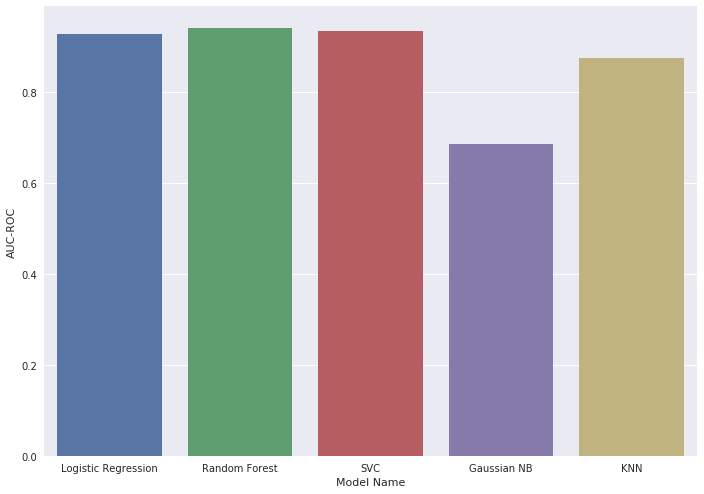

In [125]:
sns.set(style="whitegrid")
#tips = sns.load_dataset("tips")
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.barplot( x="Model Name",y="AUC-ROC", data=dataset)

## IV. Final Verdict - Random Forest

In [71]:
def label_map(out):
    pre=clf1.predict(out)
    a = mlb.inverse_transform(pre)
    return a

In [72]:
df1.iloc[1295]['side_effect']

['Traumatic liver injury',
 'Diarrhoea',
 'Ascites',
 'Liver injury',
 'Nausea',
 'Vomiting',
 'Hepatic function abnormal',
 'Gastritis',
 'Constipation',
 'Abdominal distension']

## V. Prediction of Side Effect

In [73]:
print("For the Pubchem ID: ",df1['pubchem_id'][1295],", the possible side effects affecting the DIGESTIVE System are \nPredicted:\n",label_map(X_test.loc[1295].to_frame().T),"\nActual:\n",df1['side_effect'][1295])

For the Pubchem ID:  25077405 , the possible side effects affecting the DIGESTIVE System are 
Predicted:
 [('Abdominal pain', 'Constipation', 'Diarrhoea', 'Gastrointestinal disorder', 'Gastrointestinal pain', 'Nausea', 'Vomiting')] 
Actual:
 ['Traumatic liver injury', 'Diarrhoea', 'Ascites', 'Liver injury', 'Nausea', 'Vomiting', 'Hepatic function abnormal', 'Gastritis', 'Constipation', 'Abdominal distension']


In [74]:
print("For the Pubchem ID: ",df1['pubchem_id'][406],", the possible side effects affecting the DIGESTIVE System are \nPredicted:\n",label_map(X_test.loc[406].to_frame().T),"\nActual:\n",df1['side_effect'][406])

For the Pubchem ID:  3902 , the possible side effects affecting the DIGESTIVE System are 
Predicted:
 [('Abdominal pain', 'Constipation', 'Diarrhoea', 'Dry mouth', 'Dyspepsia', 'Gastrointestinal disorder', 'Gastrointestinal pain', 'Nausea', 'Vomiting')] 
Actual:
 ['Thirst', 'Hepatobiliary disease', 'Dyspepsia', 'Diarrhoea', 'Gastrointestinal pain', 'Gastrointestinal disorder', 'Stomatitis', 'Dry mouth', 'Nausea', 'Vomiting', 'Abdominal pain', 'Constipation', 'Hepatitis']


In [126]:
print("For the Pubchem ID: ",df1['pubchem_id'][55],", the possible side effects affecting the DIGESTIVE System are \nPredicted:\n",label_map(X_test.loc[55].to_frame().T),"\nActual:\n",df1['side_effect'][55])

For the Pubchem ID:  1546 , the possible side effects affecting the DIGESTIVE System are 
Predicted:
 [('Abdominal pain', 'Constipation', 'Diarrhoea', 'Dyspepsia', 'Gastrointestinal disorder', 'Gastrointestinal pain', 'Hepatobiliary disease', 'Nausea', 'Stomatitis', 'Vomiting')] 
Actual:
 ['Intestinal infections', 'Pharyngitis', 'Constipation', 'Gastrointestinal disorder', 'Oral candidiasis', 'Hepatic failure', 'Blood bilirubin increased', 'Diarrhoea', 'Flatulence', 'Nausea', 'Abdominal discomfort', 'Ileus', 'Vomiting', 'Gastrointestinal pain', 'Abdominal pain', 'Hepatobiliary disease', 'Breath sounds abnormal']


## END